In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
sns.set(color_codes=True) # Set style and color of graphs

train = pd.read_csv("/Users/houzhuo/Downloads/train.csv")
test    = pd.read_csv("/Users/houzhuo/Downloads/test.csv")
full = train.append(test,ignore_index=True)
titanic = full[:891]
print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)
full.info()

/Users/houzhuo/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('Datasets:', 'full:', (1309, 12), 'titanic:', (891, 12))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


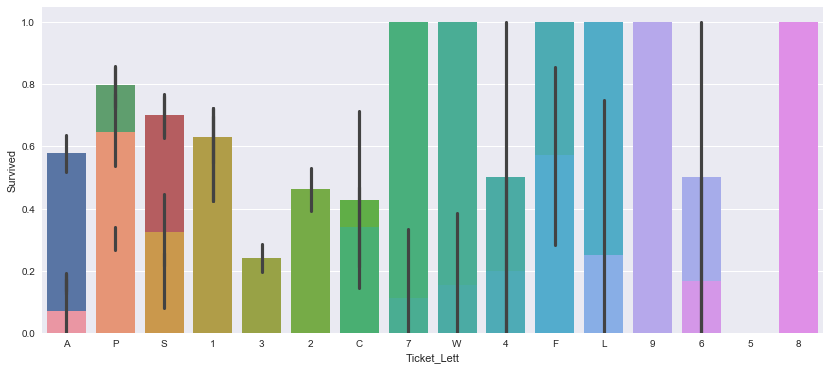

In [2]:
#Title
title = pd.DataFrame()
full['Title'] = full['Name'].map(lambda name:name.split(',')[1].split( '.' )[0].strip())
plt.figure(figsize=(14,6))
sns.barplot('Title', 'Survived', data=full)
#plt.show()
full['Title'] = full['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
full['Title'] = full['Title'].replace(['Mlle','Ms'], 'Miss')
full['Title'] = full['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
title = pd.get_dummies(full['Title'],prefix='Title')
full = pd.concat([full,title],axis=1)
sns.barplot('Title', 'Survived', data=full)

#Age & isChild
group = full.groupby(['Sex','Title', 'Pclass'])['Age']
full['Age'] = group.transform(lambda x: x.fillna(x.median()))
full['IsChild'] = np.where(full['Age']<=12,1,0)
full['IsOld'] = np.where(full['Age']>=63,1,0)

#Dead_female_family & Survive_male_family
full['Surname'] = full['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(full[(full.Sex=='female') & (full.Age>=12)
                              & (full.Survived==0) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(full[(full.Sex=='male') & (full.Age>=12)
                              & (full.Survived==1) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
full['Dead_female_family'] = np.where(full['Surname'].isin(dead_female_surname),0,1)
full['Survive_male_family'] = np.where(full['Surname'].isin(survive_male_surname),0,1)
#full = full.drop(['Name','Surname'],axis=1)

#FamilySize
full['FamilySize'] = np.where(full['SibSp']+full['Parch']==0, 'Alone',
                                    np.where(full['SibSp']+full['Parch']<=3, 'Small', 'Big'))
sns.barplot('FamilySize', 'Survived', data=full)
df = pd.get_dummies(full['FamilySize'],prefix='FamilySize')
full = pd.concat([full,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)

#Ticket_letter
full['Ticket_Lett'] = full['Ticket'].apply(lambda x: str(x)[0])
full['Ticket_Lett'] = full['Ticket_Lett'].apply(lambda x: str(x))
sns.barplot('Ticket_Lett', 'Survived', data=full)
full['High_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
full['Low_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['A','W','3','7']),1,0)
#full = full.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
#full = full.drop('Embarked',axis=1)
full['Embarked_isC'] = np.where(full['Embarked']=='C',1,0)
#sns.barplot('Embarked_isC','Survived',data=full)

#Cabin
full[ 'Cabin' ] = full.Cabin.fillna( 'U' )
full['Cabin_isNull'] = np.where(full['Cabin']=='U',1,0)
#sns.barplot('Cabin_isNull','Survived',data=full)
full = full.drop('Cabin',axis=1)

#PClass
df = pd.get_dummies(full['Pclass'],prefix='Pclass')
full = pd.concat([full,df],axis=1).drop('Pclass',axis=1)

#Sex
full['Sex'] = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

#Fare
full['Fare'].fillna(full['Fare'].dropna().median(),inplace=True)
full['Low_Fare'] = np.where(full['Fare']<=8.66,1,0)
full['High_Fare'] = np.where(full['Fare']>=26,1,0)
#Ticket_count
#full["TicketCount"] = full.Ticket.apply(lambda x: 1 if x in full.Ticket.unique() and
                                        #full.Ticket.value_counts()[x] > 1  else 0)
#np.where(full['TicketCount']=='CA. 2343')
#full["TicketCount"]

In [3]:
full_X = full
full_X = full_X.drop('PassengerId',axis=1)
full_X = full_X.drop('Survived',axis=1)
full_X = full_X.drop('Embarked',axis=1)
full_X = full_X.drop('Age',axis=1)
full_X = full_X.drop('Name',axis=1)
full_X = full_X.drop('Surname',axis=1)
full_X = full_X.drop('Title',axis=1)
full_X = full_X.drop('Fare',axis=1)
full_X = full_X.drop('Ticket',axis=1)
full_X = full_X.drop('Ticket_Lett',axis=1)

In [4]:
X_train= full_X[ 0:891 ]
y_train = titanic.Survived
X_test = full_X[ 891: ]
print (full_X.shape , X_train.shape , X_test.shape , y_train.shape )
X_train.info()

((1309, 21), (891, 21), (418, 21), (891,))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
Sex                     891 non-null int64
Title_Master            891 non-null uint8
Title_Miss              891 non-null uint8
Title_Mr                891 non-null uint8
Title_Mrs               891 non-null uint8
IsChild                 891 non-null int64
IsOld                   891 non-null int64
Dead_female_family      891 non-null int64
Survive_male_family     891 non-null int64
FamilySize_Alone        891 non-null uint8
FamilySize_Big          891 non-null uint8
FamilySize_Small        891 non-null uint8
High_Survival_Ticket    891 non-null int64
Low_Survival_Ticket     891 non-null int64
Embarked_isC            891 non-null int64
Cabin_isNull            891 non-null int64
Pclass_1                891 non-null uint8
Pclass_2                891 non-null uint8
Pclass_3                891 non-null uint8
Low_Fare                891 non-nul

In [ ]:
!pip install mlxtend  

In [27]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 50,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'bootstrap': False 
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':50,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 50,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
        'n_estimators':51,
        'max_depth':5,
        'min_samples_split':12,
        'min_samples_leaf':1, 
        'random_state':10, 
        #'max_features':11
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

knn_params = {
    'n_neighbors' : 3
    }
lr_params = {
    'tol':0.0001,
    'C':1.0
    }

nb_params = {
    
    }

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)
rf = RandomForestClassifier(**rf_params)
nb = GaussianNB()
lr = LogisticRegression(**lr_params)
svc = SVC(**svc_params)
gb = GradientBoostingClassifier(**gb_params)
sclf = StackingClassifier(classifiers=[knn, rf, nb, svc, lr], 
                          meta_classifier=gb)

print('5-fold cross validation:\n')

for clf, label in zip([knn, rf, nb, svc, lr, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'SVC',
                       'LogisticRegression',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train, 
                                              cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.85 (+/- 0.03) [KNN]
Accuracy: 0.88 (+/- 0.02) [Random Forest]
Accuracy: 0.83 (+/- 0.05) [Naive Bayes]
Accuracy: 0.85 (+/- 0.01) [SVC]
Accuracy: 0.89 (+/- 0.02) [LogisticRegression]
Accuracy: 0.86 (+/- 0.02) [StackingClassifier]


In [29]:

sclf.fit(X_train,y_train)
scores = model_selection.cross_val_score(sclf, X_train, y_train, 
                                              cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.86 (+/- 0.02) [StackingClassifier]


In [30]:
y_test = sclf.predict( X_test )

passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': y_test.astype(np.int64) } )
#test.shape
#test.head()
test.to_csv( 'titanic_pred.csv' , index = False )